# Predicting the NBA All-Stars with Machine Learning

The goal of this analysis is to predict the NBA All-Stars for a given year, based on NBA player data and All-Star selections in other years. This is accomplished by applying several machine learning classification algorithms on NBA player performance data. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA player data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel, MyCM

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns

import operator
import sys

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition import PCA
from sklearn.mixture       import GaussianMixture
from sklearn.cluster       import KMeans, SpectralClustering

from sklearn.linear_model          import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.svm                   import LinearSVC #, SVC
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble              import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble              import BaggingClassifier, VotingClassifier
from sklearn.neural_network        import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #, QuadraticDiscriminantAnalysis
#from sklearn.naive_bayes           import GaussianNB
#from sklearn.gaussian_process      import GaussianProcessClassifier

from sklearn.model_selection import cross_validate, LeaveOneGroupOut

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
#from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## User input

Choose the year you want to predict, between 2000 and 2018. The years that are not selected are used for cross-validation and training of the ML algorithms.

In [2]:
test_year = 2018 # Enter any year from 2000 until 2018

print("--> Test year = {}".format(test_year))

first_year = 2000 # First year for which data has been scraped
last_year  = 2018 # Last  year for which data has been scraped

train_years = list(range(first_year, last_year+1))

train_years.remove(test_year)

first_train_year = train_years[0]
last_train_year  = train_years[-1]
    
if (first_train_year < test_year < last_train_year):
    print("--> Train years = {}-{} except {}".format(first_train_year, last_train_year, test_year))
else:
    print("--> Train years = {}-{}".format(first_train_year, last_train_year))

--> Test year = 2018
--> Train years = 2000-2017


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not,
and choose the minimum number of games a player has to have played per season to be included in the analysis:

In [3]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")
    
min_num_games = 20 # Enter any number between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Advanced statistics included
--> Minimum number of games for each player = 20


## Load NBA player data

NBA player data from 2000-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions (*NBA_totals_scraper*, *NBA_advanced_scraper* and *NBA_AllStar_scraper*) in [NBAanalysissetup.py](NBAanalysissetup.py).

In [4]:
df_train, df_test = NBAanalysissetup.loaddata_allyears(train_years, test_year, includeadvancedstats)

--> Loading train year 1999-2000 ...
--> Loading train year 2000-2001 ...
--> Loading train year 2001-2002 ...
--> Loading train year 2002-2003 ...
--> Loading train year 2003-2004 ...
--> Loading train year 2004-2005 ...
--> Loading train year 2005-2006 ...
--> Loading train year 2006-2007 ...
--> Loading train year 2007-2008 ...
--> Loading train year 2008-2009 ...
--> Loading train year 2009-2010 ...
--> Loading train year 2010-2011 ...
--> Loading train year 2011-2012 ...
--> Loading train year 2012-2013 ...
--> Loading train year 2013-2014 ...
--> Loading train year 2014-2015 ...
--> Loading train year 2015-2016 ...
--> Loading train year 2016-2017 ...
--> Loading test  year 2017-2018 ...


Print table of All-Stars in *prediction_year*:

In [5]:
print_year = test_year

print("--> All-Stars {} :".format(print_year))
print("")
if (print_year == test_year):
    tmp = df_test[df_test['AS'] > 0.5]
else:
    tmp = df_train[(df_train['YEAR'] == print_year) & (df_train['AS'] > 0.5)]
display(HTML(tmp.to_html()))

--> All-Stars 2018 :



,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,TW,TC,AS,YEAR
6,LaMarcus Aldridge,C,32,SAS,70,70,2335,638,1253,0.509,27,87,0.310,611,1166,0.524,0.520,315,378,0.833,230,360,590,144,35,84,107,154,1618,24.9,0.570,0.069,0.302,10.9,17.1,14.0,11.5,0.8,3.0,7.0,29.2,6.8,3.4,10.2,0.210,2.9,0.4,3.3,3.1,45,WC,1,2018
15,Giannis Antetokounmpo,PF,23,MIL,72,72,2662,719,1345,0.535,43,133,0.323,676,1212,0.558,0.551,475,628,0.756,154,568,722,345,104,103,212,224,1956,27.7,0.603,0.099,0.467,6.9,25.1,16.0,23.6,2.0,3.3,11.6,31.2,8.5,3.4,11.9,0.215,4.2,1.8,6.0,5.4,41,EC,1,2018
36,Bradley Beal,SG,24,WAS,77,77,2791,644,1399,0.460,187,500,0.374,457,899,0.508,0.527,272,343,0.793,57,281,338,351,94,34,204,146,1747,18.5,0.564,0.357,0.245,2.3,11.4,6.9,21.1,1.7,1.1,11.6,27.8,4.1,2.4,6.5,0.111,2.7,-0.9,1.8,2.7,42,EC,1,2018
78,Jimmy Butler,SG,28,MIN,56,56,2077,417,882,0.473,69,194,0.356,348,688,0.506,0.512,340,393,0.865,75,230,305,279,108,23,103,74,1243,23.5,0.589,0.220,0.446,4.1,12.9,8.5,20.7,2.6,1.0,8.9,24.7,6.8,1.6,8.4,0.194,4.8,0.0,4.9,3.6,44,WC,1,2018
111,DeMarcus Cousins,C,27,NOP,48,48,1737,406,864,0.470,104,294,0.354,302,570,0.530,0.530,294,394,0.746,105,512,617,257,79,76,242,183,1210,22.7,0.583,0.340,0.456,6.8,31.0,19.3,23.2,2.2,3.5,18.9,31.9,1.5,3.1,4.6,0.127,2.0,3.6,5.6,3.3,43,WC,1,2018
119,Stephen Curry,PG,29,GSW,51,51,1631,428,864,0.495,212,501,0.423,216,363,0.595,0.618,278,302,0.921,36,225,261,310,80,8,153,114,1346,28.2,0.675,0.580,0.350,2.7,14.4,9.0,30.2,2.4,0.4,13.3,31.0,7.2,1.9,9.2,0.270,9.8,-1.2,8.6,4.4,56,WC,1,2018
121,Anthony Davis,PF,24,NOP,70,70,2551,729,1362,0.535,52,154,0.338,677,1208,0.560,0.554,455,545,0.835,174,602,776,162,104,174,152,150,1965,28.8,0.613,0.113,0.400,7.7,24.9,16.5,10.9,1.9,5.4,8.7,29.8,8.2,4.4,12.6,0.237,2.9,2.1,5.1,4.5,43,WC,1,2018
129,DeMar DeRozan,SG,28,TOR,75,75,2556,615,1337,0.460,84,270,0.311,531,1067,0.498,0.491,444,539,0.824,56,239,295,390,81,19,167,141,1758,21.4,0.558,0.202,0.403,2.5,10.3,6.5,24.9,1.6,0.6,9.6,29.8,6.7,2.5,9.2,0.173,2.9,-1.0,1.9,2.5,55,EC,1,2018
137,Goran Dragic,PG,31,MIA,72,72,2295,467,1041,0.449,107,292,0.366,360,749,0.481,0.500,214,267,0.801,53,239,292,347,59,12,159,174,1255,16.6,0.542,0.280,0.256,2.6,11.8,7.2,25.5,1.3,0.4,12.1,25.8,2.9,2.2,5.1,0.107,1.1,-1.1,0.0,1.1,41,EC,1,2018
139,Andre Drummond,C,24,DET,75,75,2504,446,845,0.528,0,8,0.000,446,837,0.533,0.528,235,380,0.618,384,814,1198,228,111,124,192,239,1127,23.3,0.557,0.009,0.450,16.5,36.6,26.4,14.5,2.2,4.4,15.9,21.3,4.5,5.6,10.1,0.194,0.3,5.4,5.7,4.9,37,EC,1,2018


Print table of non-All-Stars in *prediction_year*:

Select only players which have played at least *min_num_games* number of games in a season:

In [6]:
print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])
print("")

df_train = df_train[df_train['G'] >= min_num_games]
df_test  = df_test [df_test ['G'] >= min_num_games]

print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])

# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players in train set = 8240
--> # of players in test  set = 531

--> # of players in train set = 7082
--> # of players in test  set = 400


NaN handling:

In [7]:
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_train[['TS%', '3PAr', 'FTr']] = df_train[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_test [['TS%', '3PAr', 'FTr']] = df_test [['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Remove remaining players with NaNs, if necessary:

if (df_train.shape[0] - df_train.dropna().shape[0] != 0):
    #print("--> Players in train set with NaNs:")
    #print(df_train[df_train.isnull().any(axis=1)])
    #print("")
    df_train.dropna(inplace=True)
    print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])

if (df_test.shape[0] - df_test.dropna().shape[0] != 0):
    #print("--> Players in test set with NaNs:")
    #print(df_test[df_test.isnull().any(axis=1)])
    #print("")
    df_test.dropna(inplace=True)
    print("--> # of players with NaNs in test  set =", df_test.shape[0] - df_test.dropna().shape[0])
    
# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players with NaNs in train set = 827
--> # of players with NaNs in test  set = 22

--> # of players with NaNs in train set = 0
--> # of players with NaNs in test  set = 0



Check number of All-Stars in dataframes:

In [8]:
# Check All-Star data in data files:

all_years = train_years[:]
all_years.append(test_year)

n_AS_dict = {} 

for year in all_years:
    shellcommand = "wc -l data/NBA_allstars_{}-{}.csv | awk '{{print $1}}'".format(year-1, year)
    n = !{shellcommand}
    n_AS_dict[year] = int(n[0]) - 1 # Don't count header
    
# Check All-Star data in dataframes:

for year in train_years:
    n_AS_df  = df_train[(df_train['YEAR'] == year) & (df_train['AS'] > 0.5)].shape[0]
    n_AS_tot = n_AS_dict[year]
    n_tot    = df_train[(df_train['YEAR'] == year)].shape[0]
    print("--> Train year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(year, n_AS_df, n_AS_tot, n_tot))
    
n_AS_df  = df_test[df_test['AS'] > 0.5].shape[0]
n_AS_tot = n_AS_dict[test_year]
n_tot    = df_test.shape[0]
print("--> Test  year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(test_year, n_AS_df, n_AS_tot, n_tot))

--> Train year 2000: 24 out of 24 All-Stars in analysis (Total # of players = 378)
--> Train year 2001: 26 out of 28 All-Stars in analysis (Total # of players = 375)
--> Train year 2002: 26 out of 26 All-Stars in analysis (Total # of players = 379)
--> Train year 2003: 25 out of 25 All-Stars in analysis (Total # of players = 362)
--> Train year 2004: 24 out of 24 All-Stars in analysis (Total # of players = 372)
--> Train year 2005: 24 out of 24 All-Stars in analysis (Total # of players = 388)
--> Train year 2006: 25 out of 25 All-Stars in analysis (Total # of players = 404)
--> Train year 2007: 29 out of 29 All-Stars in analysis (Total # of players = 395)
--> Train year 2008: 26 out of 26 All-Stars in analysis (Total # of players = 385)
--> Train year 2009: 26 out of 26 All-Stars in analysis (Total # of players = 384)
--> Train year 2010: 28 out of 28 All-Stars in analysis (Total # of players = 391)
--> Train year 2011: 24 out of 25 All-Stars in analysis (Total # of players = 399)
--> 

Prepare data and create features (*X*) and target (*y*) dataframes needed for Scikit-learn methods:

In [9]:
# Features dataframes (AS and YEAR are dropped: AS is the target variable, YEAR is only used for cross-validation):

X_train = df_train.drop(['AS', 'YEAR'], axis=1)
X_test  = df_test .drop(['AS', 'YEAR'], axis=1)

X_list = [X_train, X_test]

for X in X_list:
    
    # Remove features:

    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',                             # No predictive power
            'FG', 'FGA', 'FG%', '3P%', '2P%', 'FT%', 'eFG%', 'TRB', 'PTS'], # Correlated with other features
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['TS%', '3PAr', 'FTr', 'TRB%', 'WS', 'WS/48', 'BPM',         # Correlated with other features 
                'ORB', 'DRB', 'AST', 'TOV', 'STL', 'BLK'],                  # Correlated with other features
               axis=1, inplace=True) 
    
    # Replace GS by GS/G, and MP by MP/G:

    X['GS'] = X['GS'].div(X['G'].values, axis=0).round(2)
    X['MP'] = X['MP'].div(X['G'].values, axis=0).round(1)
    X['TW'] = X['TW'].div(82, axis=0)           .round(2)
    X.rename(columns={'GS': 'GS/G', 'MP': 'MP/G', 'TW': 'TW/82'}, inplace=True)
    
    '''
    # Scale total-type features by MP/48:

    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']] = \
    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']].div(X['MP/48'].values, axis=0)
    X.rename(columns={'3P': '3P/48', '3PA': '3PA/48', 'FT': 'FT/48', 'FTA': 'FTA/48', 
                      '2P': '2P/48', '2PA': '2PA/48', 'PF': 'PF/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']] = \
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'ORB': 'ORB/48', 'DRB': 'DRB/48', 'AST': 'AST/48', 'PF': 'PF/48',
                          'BLK': 'BLK/48', 'TOV': 'TOV/48', 'STL': 'STL/48'}, inplace=True)
    '''
    
# Target dataframes (target = AS, a binary variable introduced to indicate All-Star status):

y_train = df_train['AS']
y_test  = df_test ['AS']

print("--> Train data set : # of players = {:4}, # of features = {}".format(X_train.shape[0], X_train.shape[1]))
print("--> Test  data set : # of players = {:4}, # of features = {}".format(X_test.shape[0],  X_test.shape[1] ))
print("")

print("--> Model features : ", list(X_train.columns))

--> Train data set : # of players = 7082, # of features = 24
--> Test  data set : # of players =  400, # of features = 24

--> Model features :  ['G', 'GS/G', 'MP/G', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF', 'PER', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'VORP', 'TW/82']


Scale feature dataframes to accommodate ML algorithms:

In [10]:
feature_names = X_train.columns # This is no longer available after transformation with scaler

#X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler() # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_train = X_scaler.fit_transform(X_train) # Fit scaler to training data and transform X_train

X_test  = X_scaler.transform(X_test) # Transform X_test using fitted scaler

## Unsupervised Learning: PCA & Clustering

Explore features of All-Stars and non-All-Stars by plotting (some of) their distributions in training data:

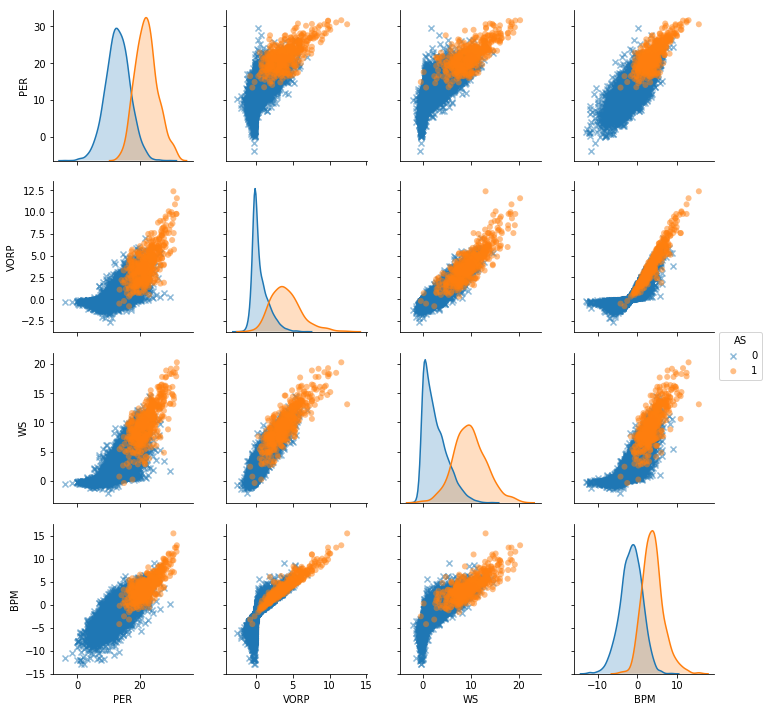

In [11]:
if includeadvancedstats:
    plotvariables = ['PER', 'VORP', 'WS', 'BPM']
else:
    plotvariables = ['PTS', 'eFG%', 'MP']

_ = sns.pairplot(df_train, vars=plotvariables, hue="AS", diag_kind="kde", diag_kws=dict(shade=True),
                 markers = ['x','o'], plot_kws=dict(edgecolor="none", alpha=0.5))

Use Principal Component Analysis for dimensionality reduction and plot result:

--> Training data in the PCA1-PCA2 plane, where PCA1 and PCA2 represent the
    two principal axes in feature space of maximum variance in the data:


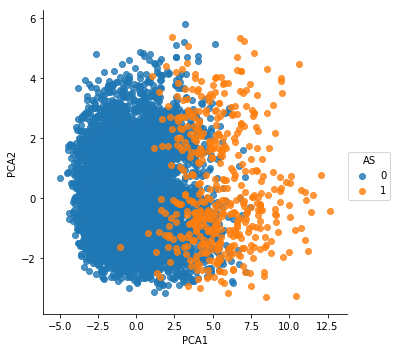

In [12]:
model = PCA(n_components=2, svd_solver='randomized') # Instantiate PCA model with hyperparameters

model.fit(X_train)                                   # Fit model to data (unsupervised: y is not specified)

X_2D = model.transform(X_train)                      # Transform the data to two PCA dimensions

df_train['PCA1'] = X_2D[:, 0] 
df_train['PCA2'] = X_2D[:, 1]

print("--> Training data in the PCA1-PCA2 plane, where PCA1 and PCA2 represent the")
print("    two principal axes in feature space of maximum variance in the data:")

_ = sns.lmplot("PCA1", "PCA2", data=df_train, hue='AS', fit_reg=False)

Apply clustering algorithms to identify clusters in the training data and plot clusters:

--> KMeans clusters:


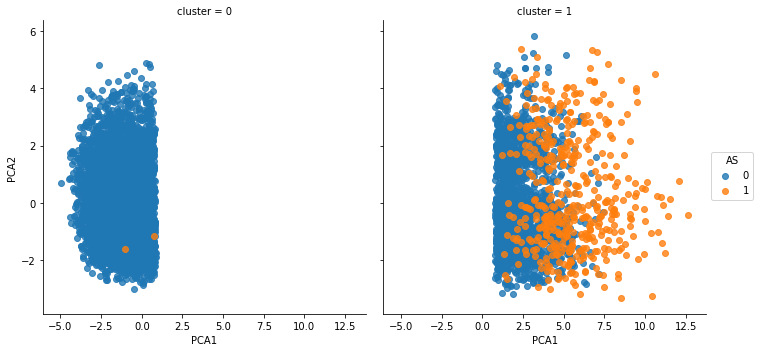

--> Gaussian Mixture clusters:


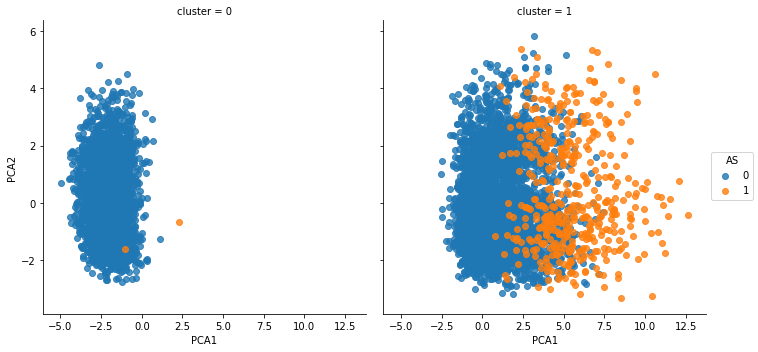

--> Spectral Clustering clusters:


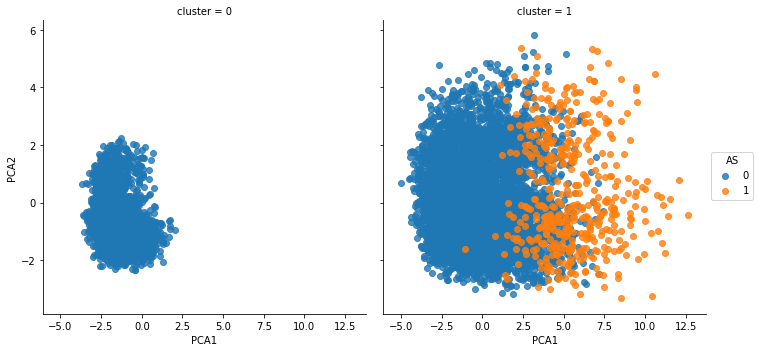

In [13]:
cluster_models = []

estimator_name = 'KMeans'
estimator = KMeans(n_clusters=2, init='random')                      # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

estimator_name = 'Gaussian Mixture'
estimator = GaussianMixture(n_components=2, covariance_type='full')  # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

estimator_name = 'Spectral Clustering'
estimator = SpectralClustering(n_clusters=2)                         # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

for model in cluster_models:
                      
    model[1].fit(X_train)                                # Fit model to data (unsupervised: y is not specified)
    
    if hasattr(model[1], 'labels_'):                     # Determine cluster labels
        y_prediction = model[1].labels_.astype(np.int)
    else:
        y_prediction = model[1].predict(X_train)

    df_train['cluster'] = y_prediction

    print("-->", model[0], "clusters:")
    sns.lmplot("PCA1", "PCA2", data=df_train, hue='AS', col='cluster', fit_reg=False)
    plt.show()

#### Unsupervised Learning Conclusion: 

The unsupervised learning algorithms tested in this analysis are unable to identify the NBA All-Stars and non-All-Stars as separate clusters.

## Supervised Learning: Classification

Select ML classifiers, set hyper-parameters and instantiate models:

In [14]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

models = []

estimator_name = 'Logistic Regression Classifier'
C = 100  # A smaller value for C results in more regularization (variance reduction due to noise in data)
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity)  => Feature selection, 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage) => Coefficient suppression
estimator = LogisticRegression(C=C, penalty=p)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Nearest Neighbours Classifier' # (CV is slowww)
n_n = 5
w   = 'uniform' # 'distance'
estimator = KNeighborsClassifier(n_neighbors=n_n, weights=w)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Support Vector Machine Classifier'
estimator_name = 'Linear Support Vector Machine Classifier'
#k = 'rbf' # 'linear' # 'poly', 'rbf'
#d = 3 # for kernel='poly'
C = 1
p = 'l2'
#estimator = SVC(kernel=k, degree=d, probability=True, C=C, random_state=rseed)
estimator = LinearSVC(C=C, penalty=p, dual=False)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Stochastic Gradient Descent Classifier'
l = 'hinge' # 'log', 'modified_huber', 'squared_hinge', 'perceptron'
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity), 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage)
estimator = SGDClassifier(loss=l, penalty=p, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Decision Tree Classifier'
estimator_name = 'Bagged Decision Tree Classifier'
m_d = None
m_f = 'auto'
#estimator = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
dtc = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, random_state=rseed)
estimator = BaggingClassifier(base_estimator=dtc, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Random Forest Classifier'
n_e = 100
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=sqrt(n_features) 
estimator = RandomForestClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extremely Randomized Trees Classifier'
n_e = 100
m_d = None
m_f = 'auto'
estimator = ExtraTreesClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gradient Boost Classifier'
n_e = 100
m_d = 3
l_l = 0.1
estimator = GradientBoostingClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'AdaBoost Classifier'
n_e = 100
l_l = 0.1
estimator = AdaBoostClassifier(n_estimators=n_e, learning_rate=l_l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Neural Network Classifier'
a = 0.0001 # L2 penalty (regularization term) parameter
estimator = MLPClassifier(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Quadratic Discriminant Analysis Classifier'
estimator_name = 'Linear Discriminant Analysis Classifier'
#estimator = QuadraticDiscriminantAnalysis()
so = 'svd' # 'lsqr', 'eigen' (if 'svd', shrinkage should be None)
sh = None # 'auto' 
estimator = LinearDiscriminantAnalysis(solver=so, shrinkage=sh)
models.append(MyModel(estimator_name, estimator))

'''
estimator_name = 'Gaussian Process Classifier' # (CV is slowwwwwwww)
estimator = GaussianProcessClassifier(random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Naive Bayes Classifier' # (Assumes Gaussian PDFs for feature distributions)
estimator = GaussianNB()
models.append(MyModel(estimator_name, estimator))
'''

estimator_name = 'Passive Aggressive Classifier'
C = 0.001
l = 'squared_hinge' # 'hinge'
estimator = PassiveAggressiveClassifier(C=C, loss=l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

print("--> ML classifiers implemented in this analysis:")
print("")

for counter, model in enumerate(models, 1):
    print("{:2} : {}".format(counter, model.estimator_name))
    #print("     Model parameters : ", mymodel.estimator.get_params())

--> ML classifiers implemented in this analysis:

 1 : Logistic Regression Classifier
 2 : Nearest Neighbours Classifier
 3 : Linear Support Vector Machine Classifier
 4 : Stochastic Gradient Descent Classifier
 5 : Bagged Decision Tree Classifier
 6 : Random Forest Classifier
 7 : Extremely Randomized Trees Classifier
 8 : Gradient Boost Classifier
 9 : AdaBoost Classifier
10 : Neural Network Classifier
11 : Linear Discriminant Analysis Classifier
12 : Passive Aggressive Classifier


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season, and calculate some classification scores:

In [15]:
X_train = np.array(X_train) # To accommodate X_train = X_training[train_index] and X_test = X_training[test_index]
y_train = np.array(y_train) # To accommodate y_train = y_training[train_index] and y_test = y_training[test_index]

logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

cv_scores = []

modelnames = []

for model in models:
    
    model.reset()
    
    classifier      = model.estimator
    classifier_name = model.estimator_name

    modelnames.append(classifier_name)
    
    model.YEAR_cvgroups = train_years
    
    PRE_cvgroups = []
    REC_cvgroups = []
    F1_cvgroups  = []
    ACC_cvgroups = []
    FPR_cvgroups = []

    FPR_ROC_cvgroups = []
    TPR_ROC_cvgroups = []
    AUC_ROC_cvgroups = []
    PRE_PR_cvgroups  = []
    REC_PR_cvgroups  = []
    AUC_PR_cvgroups  = []
    
    print("--> Cross-validating", classifier_name, "...")
    
    for train_index, test_index in logo.split(X_train, y_train, groups=cv_groups):

        X_cvtrain = X_train[train_index]
        X_cvtest  = X_train[test_index]
        y_cvtrain = y_train[train_index]
        y_cvtest  = y_train[test_index]
                       
        classifier.fit(X_cvtrain, y_cvtrain)
    
        y_cvprediction = classifier.predict(X_cvtest) 
        y_cvtruth      = y_cvtest.tolist()
        
        CM = MyCM(confusion_matrix(y_cvtruth, y_cvprediction))
        
        PRE_cvgroups.append(CM.precision)
        REC_cvgroups.append(CM.recall)
        F1_cvgroups .append(CM.f1)
        ACC_cvgroups.append(CM.accuracy)
        FPR_cvgroups.append(CM.fpr)

        if hasattr(classifier, 'predict_proba'):
            y_cvscore = classifier.predict_proba(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore[:, 1])
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore[:, 1])
        else:
            y_cvscore = classifier.decision_function(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore)
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore)

        roc_auc = auc(fpr, tpr)
        pr_auc  = auc(rec, pre)
        rec = rec[::-1] # reverse list
        pre = pre[::-1] # reverse list
        
        FPR_ROC_cvgroups.append(fpr)
        TPR_ROC_cvgroups.append(tpr)
        AUC_ROC_cvgroups.append(roc_auc)
        PRE_PR_cvgroups.append(pre)
        REC_PR_cvgroups.append(rec)
        AUC_PR_cvgroups.append(pr_auc)
        
    model.PRE_cvgroups = PRE_cvgroups
    model.REC_cvgroups = REC_cvgroups
    model.F1_cvgroups  = F1_cvgroups
    model.ACC_cvgroups = ACC_cvgroups
    model.FPR_cvgroups = FPR_cvgroups

    model.FPR_ROC_cvgroups = FPR_ROC_cvgroups
    model.TPR_ROC_cvgroups = TPR_ROC_cvgroups
    model.AUC_ROC_cvgroups = AUC_ROC_cvgroups
    model.PRE_PR_cvgroups  = PRE_PR_cvgroups
    model.REC_PR_cvgroups  = REC_PR_cvgroups
    model.AUC_PR_cvgroups  = AUC_PR_cvgroups
    
    cv_scores.append({'Estimator'      : classifier_name, 
                      'Precision mean' : (np.mean(model.PRE_cvgroups)*100).round(1),
                      'Precision std'  : (np.std (model.PRE_cvgroups)*100).round(1),
                      'Recall mean'    : (np.mean(model.REC_cvgroups)*100).round(1),
                      'Recall std'     : (np.std (model.REC_cvgroups)*100).round(1),
                      'F1 mean'        : (np.mean(model.F1_cvgroups )*100).round(1),
                      'F1 std'         : (np.std (model.F1_cvgroups )*100).round(1),
                      'Accuracy mean'  : (np.mean(model.ACC_cvgroups)*100).round(1),
                      'Accuracy std'   : (np.std (model.ACC_cvgroups)*100).round(1),
                      'FPR mean'       : (np.mean(model.FPR_cvgroups)*100).round(1),
                      'FPR std'        : (np.std (model.FPR_cvgroups)*100).round(1)})
    
print("")
print("--> Classification scores for all models (mean and std over all years):")
print("")

columnorder = ['Estimator', 'Precision mean', 'Precision std', 'Recall mean', 'Recall std', 
               'F1 mean', 'F1 std', 'Accuracy mean', 'Accuracy std', 'FPR mean', 'FPR std']

df_cv_scores = pd.DataFrame(cv_scores, columns=columnorder)

display(HTML(df_cv_scores.to_html()))

--> Cross-validating Logistic Regression Classifier ...
--> Cross-validating Nearest Neighbours Classifier ...
--> Cross-validating Linear Support Vector Machine Classifier ...
--> Cross-validating Stochastic Gradient Descent Classifier ...
--> Cross-validating Bagged Decision Tree Classifier ...
--> Cross-validating Random Forest Classifier ...
--> Cross-validating Extremely Randomized Trees Classifier ...
--> Cross-validating Gradient Boost Classifier ...
--> Cross-validating AdaBoost Classifier ...
--> Cross-validating Neural Network Classifier ...
--> Cross-validating Linear Discriminant Analysis Classifier ...
--> Cross-validating Passive Aggressive Classifier ...

--> Classification scores for all models (mean and std over all years):



,Estimator,Precision mean,Precision std,Recall mean,Recall std,F1 mean,F1 std,Accuracy mean,Accuracy std,FPR mean,FPR std
0,Logistic Regression Classifier,81.7,6.4,71.9,9.8,75.9,5.8,97.1,0.5,1.2,0.5
1,Nearest Neighbours Classifier,82.0,5.2,63.2,10.6,70.8,7.3,96.7,0.6,1.0,0.4
2,Linear Support Vector Machine Classifier,82.3,6.8,71.9,9.8,76.1,5.4,97.1,0.5,1.1,0.6
3,Stochastic Gradient Descent Classifier,78.3,8.5,70.2,16.5,72.1,9.1,96.6,0.8,1.5,1.0
4,Bagged Decision Tree Classifier,86.2,8.1,60.9,10.5,70.5,7.2,96.7,0.7,0.8,0.6
5,Random Forest Classifier,86.0,8.0,59.9,9.6,69.7,6.3,96.7,0.5,0.7,0.5
6,Extremely Randomized Trees Classifier,86.7,7.3,62.2,10.8,71.5,7.0,96.8,0.6,0.7,0.5
7,Gradient Boost Classifier,80.0,6.9,70.6,8.9,74.5,5.7,96.9,0.6,1.3,0.6
8,AdaBoost Classifier,82.5,7.1,65.8,9.9,72.6,6.9,96.8,0.7,1.0,0.5
9,Neural Network Classifier,80.3,6.9,69.1,9.2,73.7,5.4,96.8,0.5,1.2,0.6


 Plot the Receiver Operating Characteristic curves for all models:

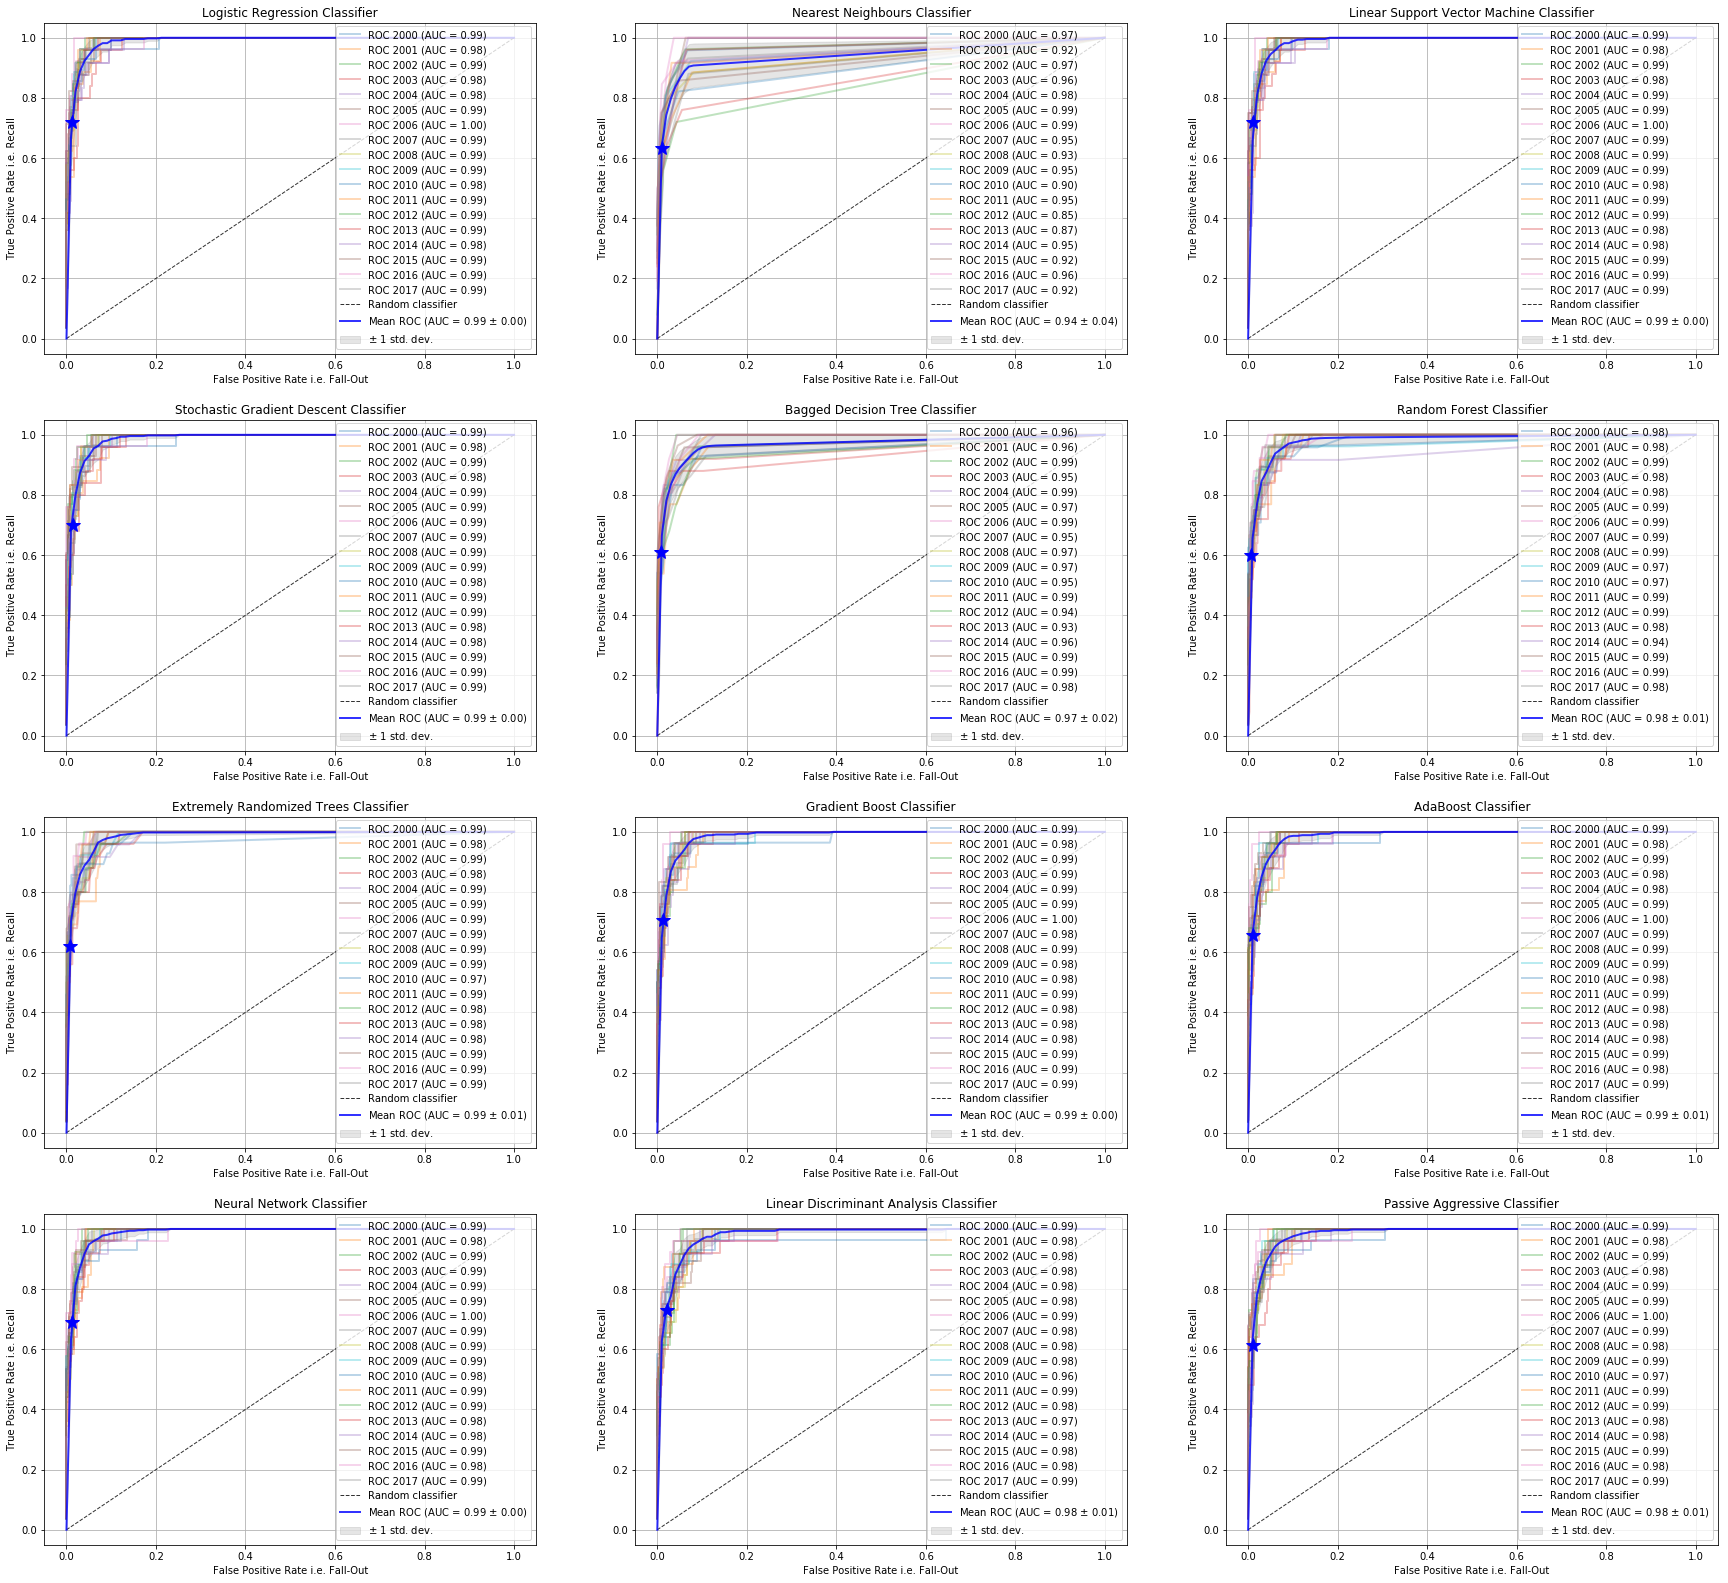

In [16]:
plt.figure(figsize=(30,28))

for imodel, model in enumerate(models):

    plt.subplot(4,3,imodel+1)
    
    tpr_linspaces = []
    fpr_linspace = np.linspace(0, 1, 100)
    
    for i in range(len(train_years)):
        
        tpr_linspaces.append(np.interp(fpr_linspace, model.FPR_ROC_cvgroups[i], model.TPR_ROC_cvgroups[i]))
        tpr_linspaces[-1][0] = 0.0
        plt.plot(model.FPR_ROC_cvgroups[i], model.TPR_ROC_cvgroups[i], lw=2, alpha=0.3, 
                 label="ROC {:d} (AUC = {:.2f})".format(train_years[i], model.AUC_ROC_cvgroups[i]))
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups), 
             marker='*', color='blue', markersize=15, zorder=20)
    
    mean_tpr_linspaces = np.mean(tpr_linspaces, axis=0)
    mean_tpr_linspaces[-1] = 1.0
    plt.plot(fpr_linspace, mean_tpr_linspaces, color='blue', lw=2, alpha=.8,
             label=r"Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})".format(np.mean(model.AUC_ROC_cvgroups), 
                                                                    np.std(model.AUC_ROC_cvgroups)))
    model.fpr_linspace       = fpr_linspace
    model.mean_tpr_linspaces = mean_tpr_linspaces
    
    std_tpr_linspaces = np.std(tpr_linspaces, axis=0)
    tpr_linspaces_upper = np.minimum(mean_tpr_linspaces + std_tpr_linspaces, 1)
    tpr_linspaces_lower = np.maximum(mean_tpr_linspaces - std_tpr_linspaces, 0)
    plt.fill_between(fpr_linspace, tpr_linspaces_lower, tpr_linspaces_upper, 
                     color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate i.e. Fall-Out")
    plt.ylabel("True Positive Rate i.e. Recall")
    plt.title(model.estimator_name)
    plt.legend(loc='lower right')
    plt.grid(True)

 Plot the Precision-Recall curves for all models:

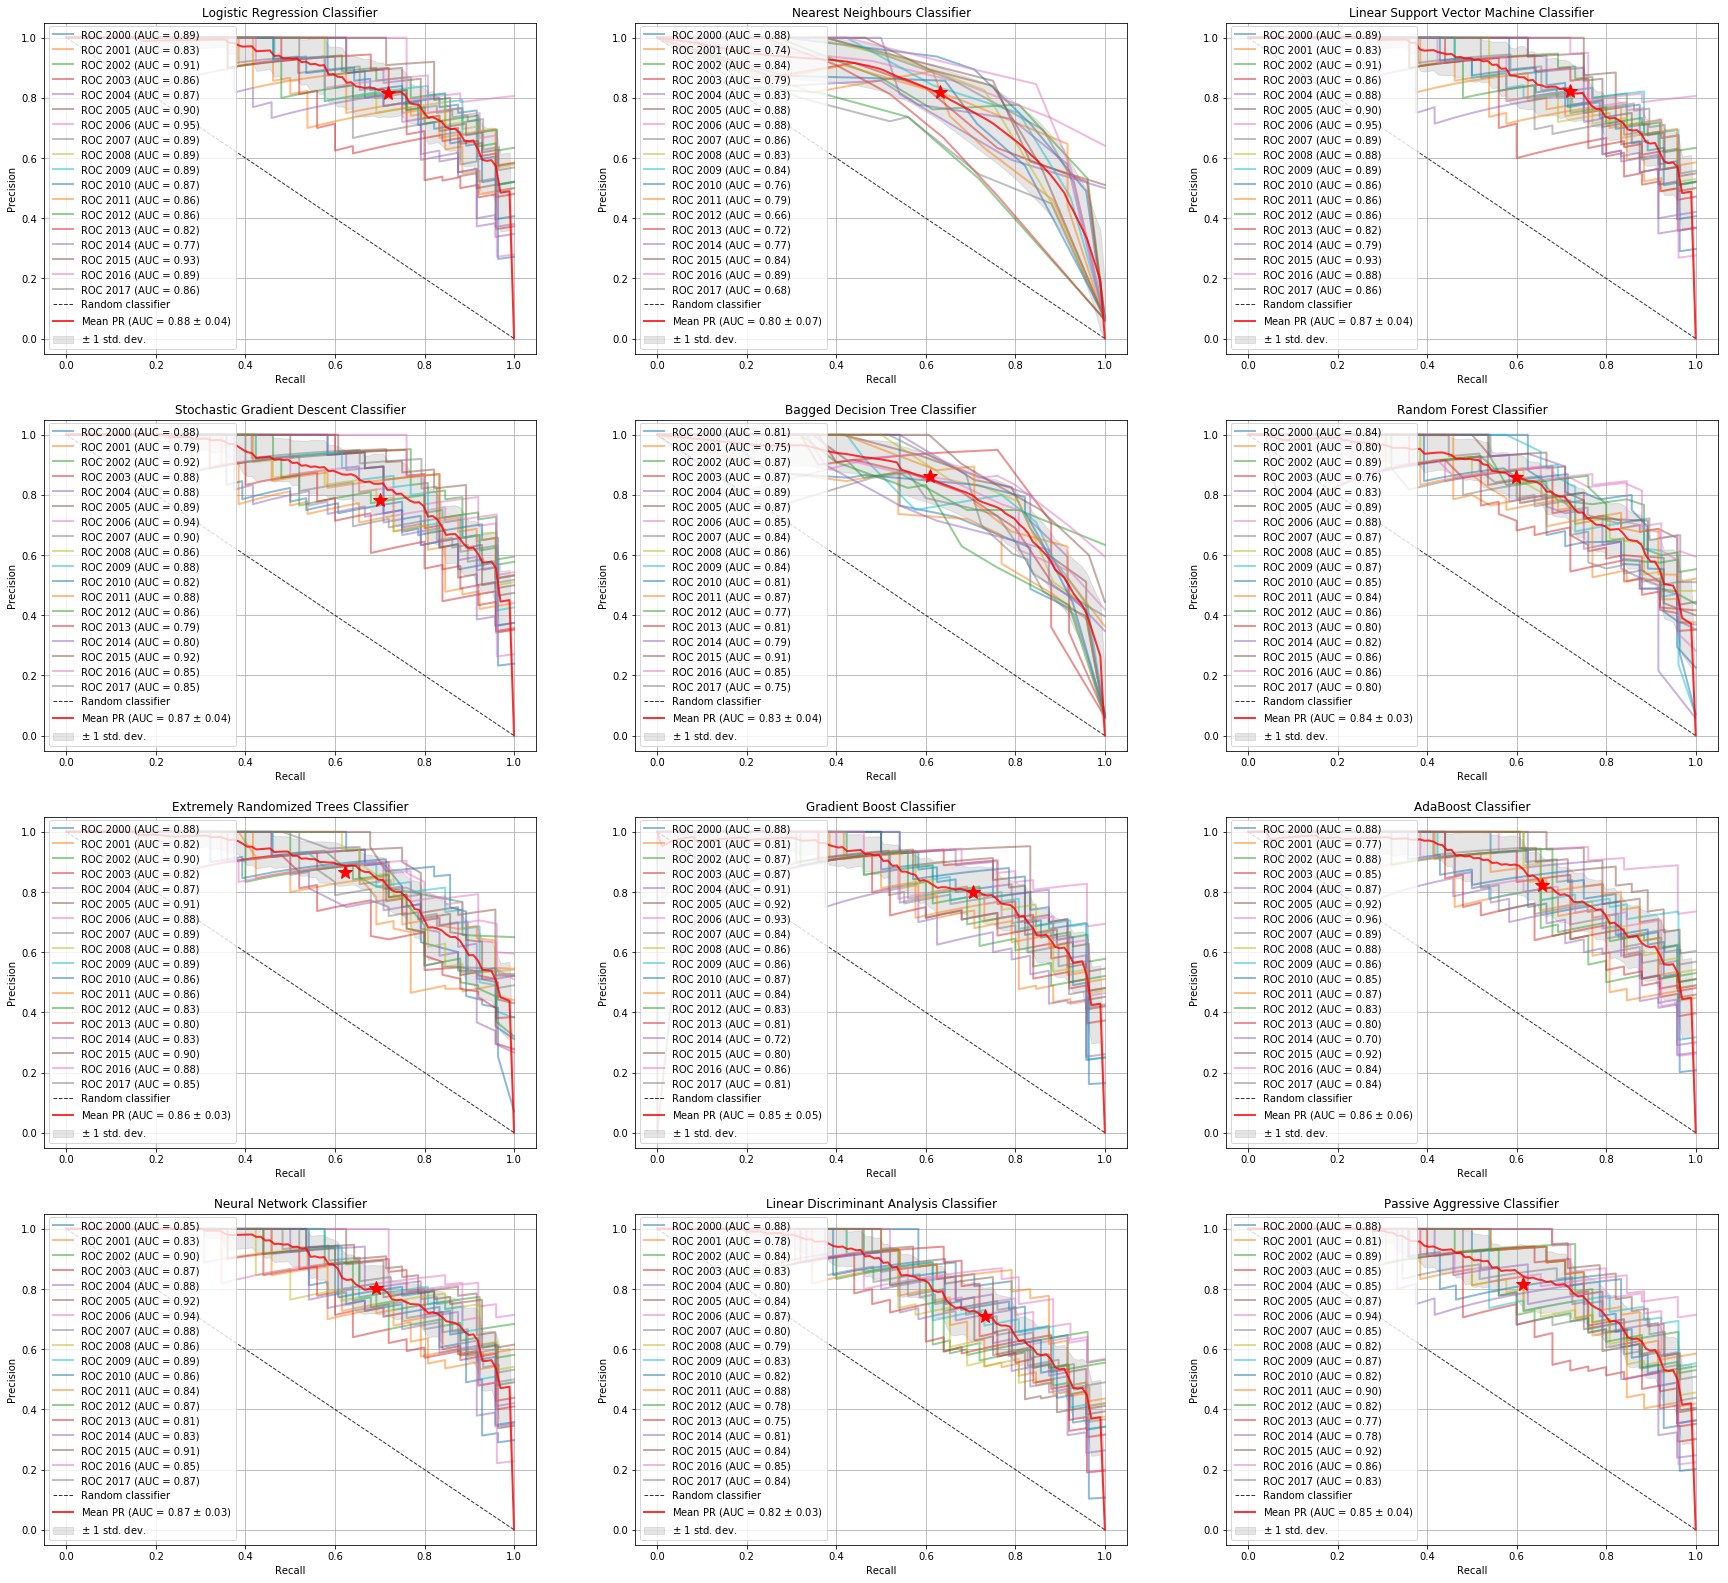

In [17]:
plt.figure(figsize=(30,28))

for imodel, model in enumerate(models):

    plt.subplot(4,3,imodel+1)
    
    pre_linspaces = []
    rec_linspace = np.linspace(0, 1, 100)
    
    for i in range(len(train_years)):
        
        pre_linspaces.append(np.interp(rec_linspace, model.REC_PR_cvgroups[i], model.PRE_PR_cvgroups[i]))
        pre_linspaces[-1][0] = 1.0
        plt.plot(model.REC_PR_cvgroups[i], model.PRE_PR_cvgroups[i], lw=2, alpha=0.5, 
                 label="ROC {:d} (AUC = {:.2f})".format(train_years[i], model.AUC_PR_cvgroups[i]))
        
    plt.plot([0, 1], [1, 0], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(np.mean(model.REC_cvgroups), np.mean(model.PRE_cvgroups), 
             marker='*', color='red', markersize=15, zorder=20)
    
    mean_pre_linspaces = np.mean(pre_linspaces, axis=0)
    mean_pre_linspaces[-1] = 0.0
    plt.plot(rec_linspace, mean_pre_linspaces, color='red', lw=2, alpha=.8,
             label=r"Mean PR (AUC = {:0.2f} $\pm$ {:0.2f})".format(np.mean(model.AUC_PR_cvgroups), 
                                                                    np.std(model.AUC_PR_cvgroups)))
    model.rec_linspace       = rec_linspace
    model.mean_pre_linspaces = mean_pre_linspaces

    std_pre_linspaces = np.std(pre_linspaces, axis=0)
    pre_linspaces_upper = np.minimum(mean_pre_linspaces + std_pre_linspaces, 1)
    pre_linspaces_lower = np.maximum(mean_pre_linspaces - std_pre_linspaces, 0)
    plt.fill_between(rec_linspace, pre_linspaces_lower, pre_linspaces_upper, 
                     color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(model.estimator_name)
    plt.legend(loc="lower left")
    plt.grid(True)

Plot the mean ROC and PR curves for all models in single plots for comparison:

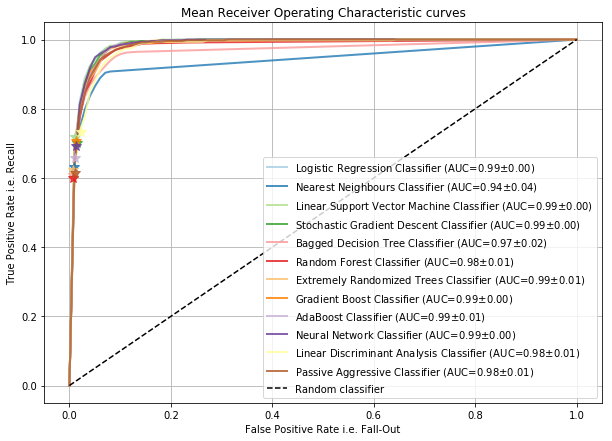

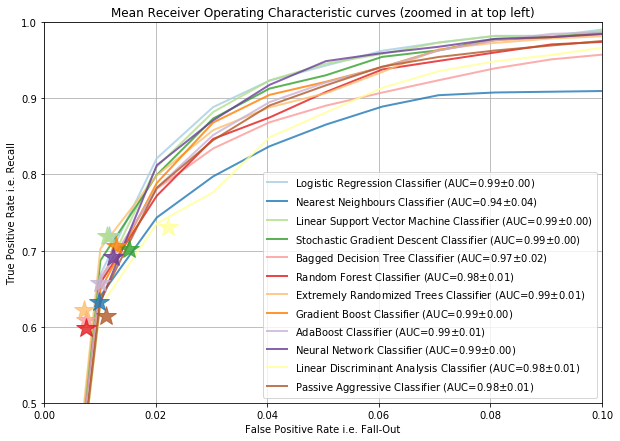

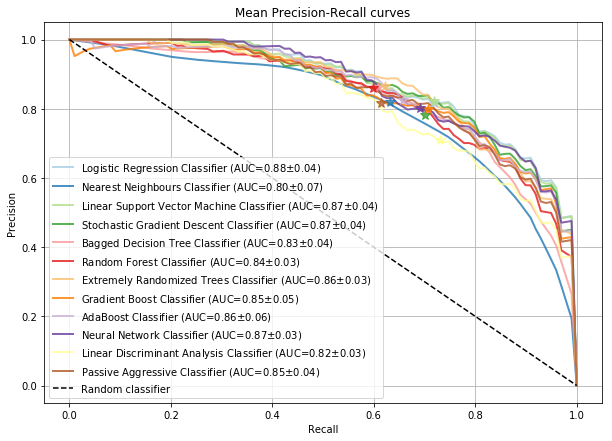

In [18]:
color = iter(plt.cm.Paired(np.linspace(0,1,12)))

plt.figure(1, figsize=(10, 7))
plt.figure(2, figsize=(10, 7))
plt.figure(3, figsize=(10, 7))

for model in models:

    c=next(color)
        
    plt.figure(1)
    label = "{} (AUC={:.2f}$\pm${:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_ROC_cvgroups), 
                                                np.std(model.AUC_ROC_cvgroups))
    plt.plot(model.fpr_linspace, model.mean_tpr_linspaces, color=c, lw=2, alpha=.8, label=label)
    plt.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups), 
             marker='*', color=c, alpha=.8, markersize=10, zorder=20)
    
    plt.figure(2)
    plt.plot(model.fpr_linspace, model.mean_tpr_linspaces, color=c, lw=2, alpha=.8, label=label)
    plt.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups),
             marker='*', color=c, alpha=.8, markersize=20, zorder=20)

    plt.figure(3)
    label = "{} (AUC={:.2f}$\pm${:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_PR_cvgroups), 
                                                np.std(model.AUC_PR_cvgroups))
    plt.plot(model.rec_linspace, model.mean_pre_linspaces, color=c, lw=2, alpha=.8, label=label)

    plt.plot(np.mean(model.REC_cvgroups), np.mean(model.PRE_cvgroups),
             marker='*', color=c, alpha=.8, markersize=10, zorder=20)

plt.figure(1)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Mean Receiver Operating Characteristic curves')
plt.legend(loc="lower right")
plt.grid(True)

plt.figure(2)
plt.xlim(0, 0.1)
plt.ylim(0.5, 1)
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Mean Receiver Operating Characteristic curves (zoomed in at top left)')
plt.legend(loc="lower right")
plt.grid(True)

plt.figure(3)
plt.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Mean Precision-Recall curves')
plt.legend(loc="lower left")
plt.grid(True)

## Model training and predictions

Fit all models to training data and use fitted models to predict the NBA All-Stars from *test_year*:

In [19]:
scores_list = []

for model in models:
    
    classifier = model.estimator

    print("--> Fitting", model.estimator_name, "...")
    
    classifier.fit(X_train, y_train)          # Fit model to training data

    y_prediction = classifier.predict(X_test) # Predict test data
    model.set_y_prediction(y_prediction)
    
    y_truth = y_test.tolist()
    model.set_y_truth(y_truth)
    
    CM = confusion_matrix(y_truth, y_prediction) # defined as: rows -> truth, columns -> prediction
    model.set_CM(CM)
    
    scores_list.append({'Estimator' : model.estimator_name, 
                        'TP'        : model.CM.TP, 
                        'FP'        : model.CM.FP, 
                        'FN'        : model.CM.FN, 
                        'TN'        : model.CM.TN, 
                        'Precision' : model.CM.precision.round(3)*100, 
                        'Recall'    : model.CM.recall.round(3)*100, 
                        'F1'        : model.CM.f1.round(3)*100, 
                        'Accuracy'  : model.CM.accuracy.round(3)*100,
                        'FPR'       : model.CM.fpr.round(3)*100})
    '''
    print("")
    print("--> Confusion matrix {}:".format(test_year))
    print(CM)
    print("")

    TN = CM[0,0] # defined as: 0 = negative, 1 = positive
    FN = CM[1,0] # defined as: 0 = negative, 1 = positive
    FP = CM[0,1] # defined as: 0 = negative, 1 = positive
    TP = CM[1,1] # defined as: 0 = negative, 1 = positive

    TOT = TP + FP + FN + TN

    print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN , TN))
    print("")
    print("--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
    print("--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) = {:5.1%}".format(FP/(FP+TN)))
    print("")

    precision = precision_score(y_test, y_prediction)
    recall    = recall_score   (y_test, y_prediction)
    f1        = f1_score       (y_test, y_prediction)
    accuracy  = accuracy_score (y_test, y_prediction)
    
    print("--> Precision score (TP/(TP+FP)) : {:.1%}".format(precision) + note1)
    print("--> Recall score    (TP/(TP+FN)) : {:.1%}".format(recall   ) + note2)
    print("--> F1 score                     : {:.1%}".format(f1       ) + note3)
    print("--> Accuracy score ((TP+TN)/TOT) : {:.1%}".format(accuracy ) + note4)
    print("")
    '''

print("")
print("--> Classification scores of all models for", test_year, ":")
print("")
    
columnorder = ['Estimator', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1', 'Accuracy', 'FPR']

df_scores = pd.DataFrame(scores_list, columns=columnorder)

display(HTML(df_scores.to_html()))

--> Fitting Logistic Regression Classifier ...
--> Fitting Nearest Neighbours Classifier ...
--> Fitting Linear Support Vector Machine Classifier ...
--> Fitting Stochastic Gradient Descent Classifier ...
--> Fitting Bagged Decision Tree Classifier ...
--> Fitting Random Forest Classifier ...
--> Fitting Extremely Randomized Trees Classifier ...
--> Fitting Gradient Boost Classifier ...
--> Fitting AdaBoost Classifier ...
--> Fitting Neural Network Classifier ...
--> Fitting Linear Discriminant Analysis Classifier ...
--> Fitting Passive Aggressive Classifier ...

--> Classification scores of all models for 2018 :



,Estimator,TP,FP,FN,TN,Precision,Recall,F1,Accuracy,FPR
0,Logistic Regression Classifier,17,2,11,370,89.5,60.7,72.3,96.8,0.5
1,Nearest Neighbours Classifier,16,2,12,370,88.9,57.1,69.6,96.5,0.5
2,Linear Support Vector Machine Classifier,17,2,11,370,89.5,60.7,72.3,96.8,0.5
3,Stochastic Gradient Descent Classifier,19,3,9,369,86.4,67.9,76.0,97.0,0.8
4,Bagged Decision Tree Classifier,16,1,12,371,94.1,57.1,71.1,96.8,0.3
5,Random Forest Classifier,14,2,14,370,87.5,50.0,63.6,96.0,0.5
6,Extremely Randomized Trees Classifier,15,0,13,372,100.0,53.6,69.8,96.8,0.0
7,Gradient Boost Classifier,17,1,11,371,94.4,60.7,73.9,97.0,0.3
8,AdaBoost Classifier,17,2,11,370,89.5,60.7,72.3,96.8,0.5
9,Neural Network Classifier,15,3,13,369,83.3,53.6,65.2,96.0,0.8


Plot Confusion Matrices for all fitted models:

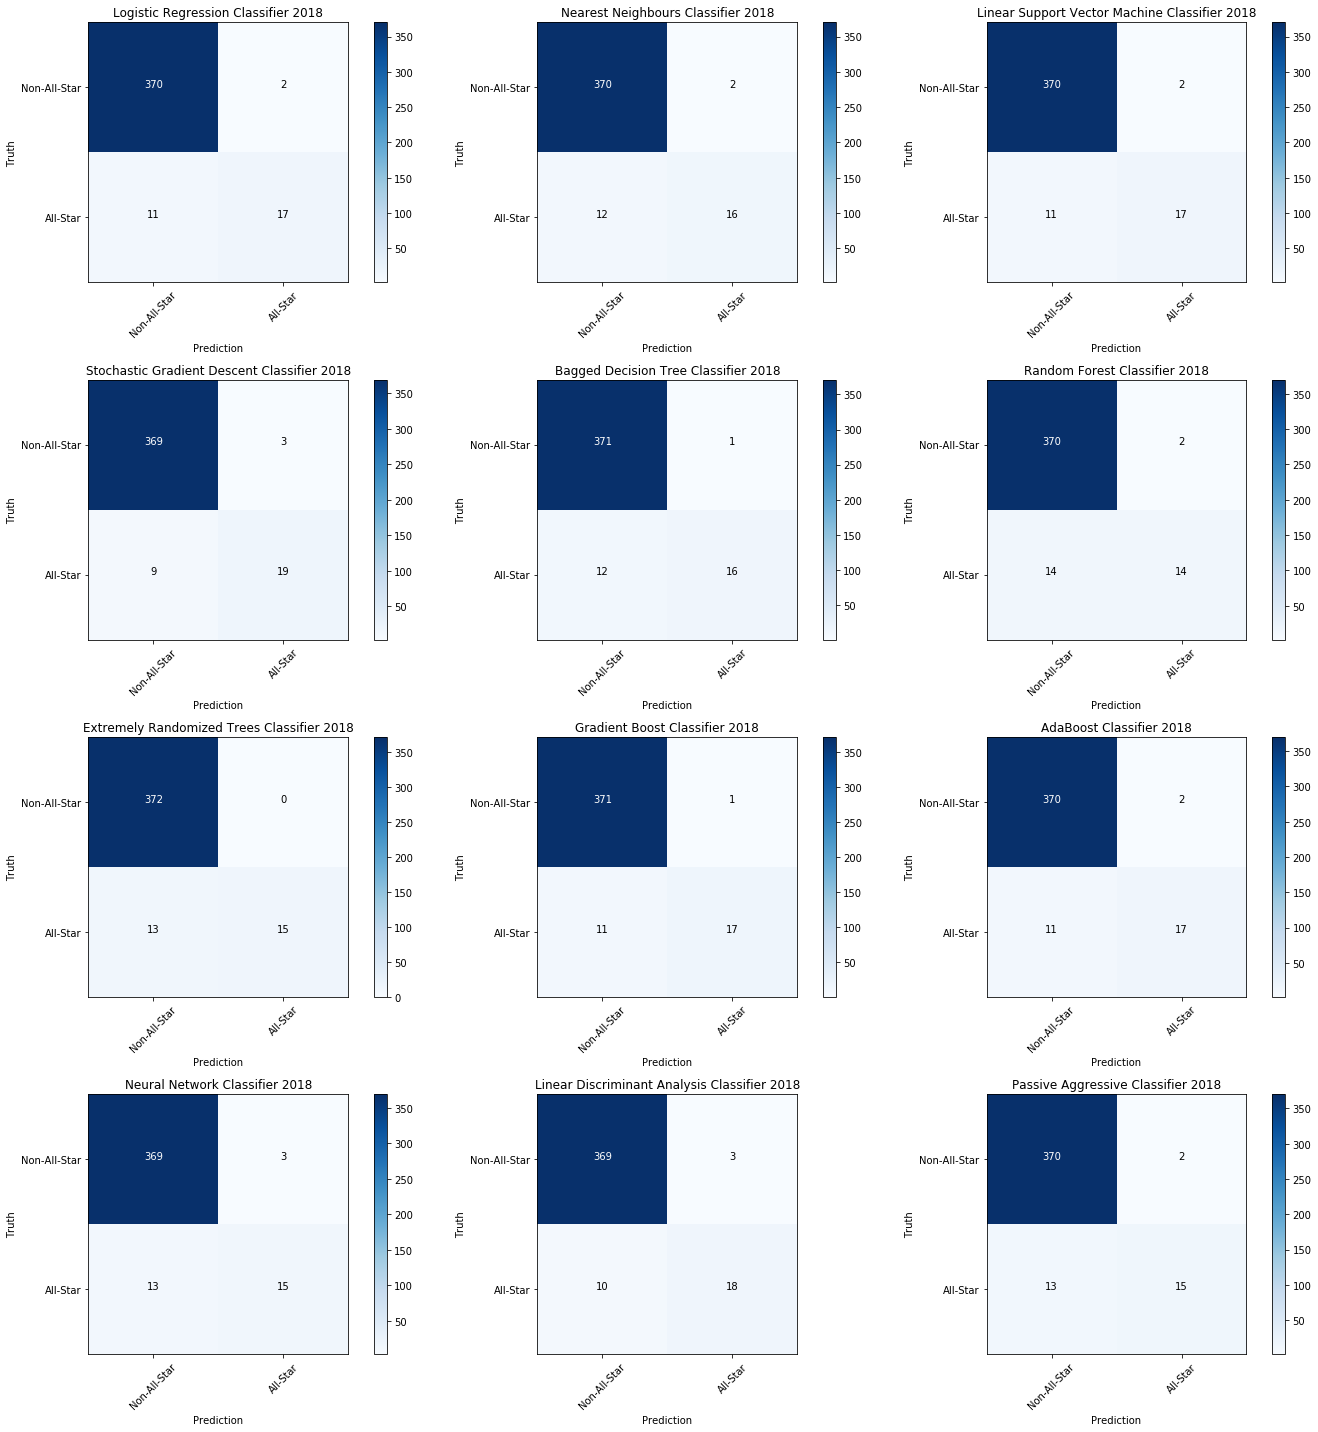

In [20]:
np.set_printoptions(precision=2)

class_names = ['Non-All-Star','All-Star']

plt.figure(figsize=(20,20))

for imodel, model in enumerate(models):

    plt.subplot(4,3,imodel+1)
    
    CM = confusion_matrix(model.y_truth, model.y_prediction)

    NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names, normalize=False,
                                           title="{} {}".format(model.estimator_name, test_year))

Print classification reports for all fitted models:

Calculate feature importances of all fitted models (if applicable):

In [21]:
df_importances = pd.DataFrame(columns=modelnames, index=feature_names)

for model in models:

    print("--> Calculating feature importances for", model.estimator_name, "...")
    #print("")
    
    if hasattr(model.estimator, "feature_importances_"):
    
        importances = model.estimator.feature_importances_
        #indices = np.argsort(importances)[::-1]
    
        for i in range(X_train.shape[1]):
            #print("----> Feature importance ({:>2}) {:6} : {:.3f}".format(i + 1, feature_names[indices[i]], importances[indices[i]]))
            df_importances.loc[feature_names[i], model.estimator_name] = (importances[i]*100).round(1)
        
        #print("")
        
print("")
print("--> Feature importances of all models:")
print("")

display(HTML(df_importances.to_html()))

--> Calculating feature importances for Logistic Regression Classifier ...
--> Calculating feature importances for Nearest Neighbours Classifier ...
--> Calculating feature importances for Linear Support Vector Machine Classifier ...
--> Calculating feature importances for Stochastic Gradient Descent Classifier ...
--> Calculating feature importances for Bagged Decision Tree Classifier ...
--> Calculating feature importances for Random Forest Classifier ...
--> Calculating feature importances for Extremely Randomized Trees Classifier ...
--> Calculating feature importances for Gradient Boost Classifier ...
--> Calculating feature importances for AdaBoost Classifier ...
--> Calculating feature importances for Neural Network Classifier ...
--> Calculating feature importances for Linear Discriminant Analysis Classifier ...
--> Calculating feature importances for Passive Aggressive Classifier ...

--> Feature importances of all models:



,Logistic Regression Classifier,Nearest Neighbours Classifier,Linear Support Vector Machine Classifier,Stochastic Gradient Descent Classifier,Bagged Decision Tree Classifier,Random Forest Classifier,Extremely Randomized Trees Classifier,Gradient Boost Classifier,AdaBoost Classifier,Neural Network Classifier,Linear Discriminant Analysis Classifier,Passive Aggressive Classifier
G,NaN,NaN,NaN,NaN,NaN,0.9,1.5,1.7,0,NaN,NaN,NaN
GS/G,NaN,NaN,NaN,NaN,NaN,11.6,13.4,3.7,6,NaN,NaN,NaN
MP/G,NaN,NaN,NaN,NaN,NaN,13.2,10.5,8.5,12,NaN,NaN,NaN
3P,NaN,NaN,NaN,NaN,NaN,0.7,1,2.2,0,NaN,NaN,NaN
3PA,NaN,NaN,NaN,NaN,NaN,1.1,1,2.1,0,NaN,NaN,NaN
2P,NaN,NaN,NaN,NaN,NaN,5,8.9,4.7,0,NaN,NaN,NaN
2PA,NaN,NaN,NaN,NaN,NaN,4.4,7.9,3.3,0,NaN,NaN,NaN
FT,NaN,NaN,NaN,NaN,NaN,7,5.5,5.2,1,NaN,NaN,NaN
FTA,NaN,NaN,NaN,NaN,NaN,8.7,6,3,0,NaN,NaN,NaN
PF,NaN,NaN,NaN,NaN,NaN,1.2,1.4,3.4,5,NaN,NaN,NaN


Calculate feature coefficients of all fitted models (if applicable):

In [22]:
df_coefficients = pd.DataFrame(columns=modelnames, index=feature_names)

for model in models:

    print("--> Calculating feature coefficients for", model.estimator_name, "...")
    #print("")
    
    if hasattr(model.estimator, "coef_"):
    
        coefficients = model.estimator.coef_.ravel()
    
        #for feature_name, feature_coef in zip(feature_names, coefficients):
        #    print("----> Model coefficient {:6} ({:2}) = {:>6.3f}".format(feature_name, counter, feature_coef))
        for i in range(X_train.shape[1]):
            df_coefficients.loc[feature_names[i], model.estimator_name] = coefficients[i].round(2)
        
        #print("")
        
print("")
print("--> Feature coefficients of all models:")
print("")

display(HTML(df_coefficients.to_html()))

--> Calculating feature coefficients for Logistic Regression Classifier ...
--> Calculating feature coefficients for Nearest Neighbours Classifier ...
--> Calculating feature coefficients for Linear Support Vector Machine Classifier ...
--> Calculating feature coefficients for Stochastic Gradient Descent Classifier ...
--> Calculating feature coefficients for Bagged Decision Tree Classifier ...
--> Calculating feature coefficients for Random Forest Classifier ...
--> Calculating feature coefficients for Extremely Randomized Trees Classifier ...
--> Calculating feature coefficients for Gradient Boost Classifier ...
--> Calculating feature coefficients for AdaBoost Classifier ...
--> Calculating feature coefficients for Neural Network Classifier ...
--> Calculating feature coefficients for Linear Discriminant Analysis Classifier ...
--> Calculating feature coefficients for Passive Aggressive Classifier ...

--> Feature coefficients of all models:



,Logistic Regression Classifier,Nearest Neighbours Classifier,Linear Support Vector Machine Classifier,Stochastic Gradient Descent Classifier,Bagged Decision Tree Classifier,Random Forest Classifier,Extremely Randomized Trees Classifier,Gradient Boost Classifier,AdaBoost Classifier,Neural Network Classifier,Linear Discriminant Analysis Classifier,Passive Aggressive Classifier
G,0.49,NaN,-0.04,-14.6,NaN,NaN,NaN,NaN,NaN,NaN,-1.54,-0.03
GS/G,7.31,NaN,1.39,25.85,NaN,NaN,NaN,NaN,NaN,NaN,0.62,0.06
MP/G,4.19,NaN,0.94,24.37,NaN,NaN,NaN,NaN,NaN,NaN,-3.63,0.12
3P,0.82,NaN,0.28,4.82,NaN,NaN,NaN,NaN,NaN,NaN,2.25,-0.06
3PA,-1.34,NaN,-0.39,0.48,NaN,NaN,NaN,NaN,NaN,NaN,-2.24,-0.05
2P,-1.15,NaN,-0.24,4.94,NaN,NaN,NaN,NaN,NaN,NaN,1.51,0.01
2PA,0.53,NaN,0.16,5.75,NaN,NaN,NaN,NaN,NaN,NaN,2.16,0.06
FT,0.27,NaN,0.1,1.79,NaN,NaN,NaN,NaN,NaN,NaN,1.27,0
FTA,-0.3,NaN,-0.08,1.03,NaN,NaN,NaN,NaN,NaN,NaN,1.38,0.04
PF,-0.98,NaN,-0.36,-6.74,NaN,NaN,NaN,NaN,NaN,NaN,-3.26,-0.28


Plot Logistic Curves for fitted Logistic Regression Classifier:

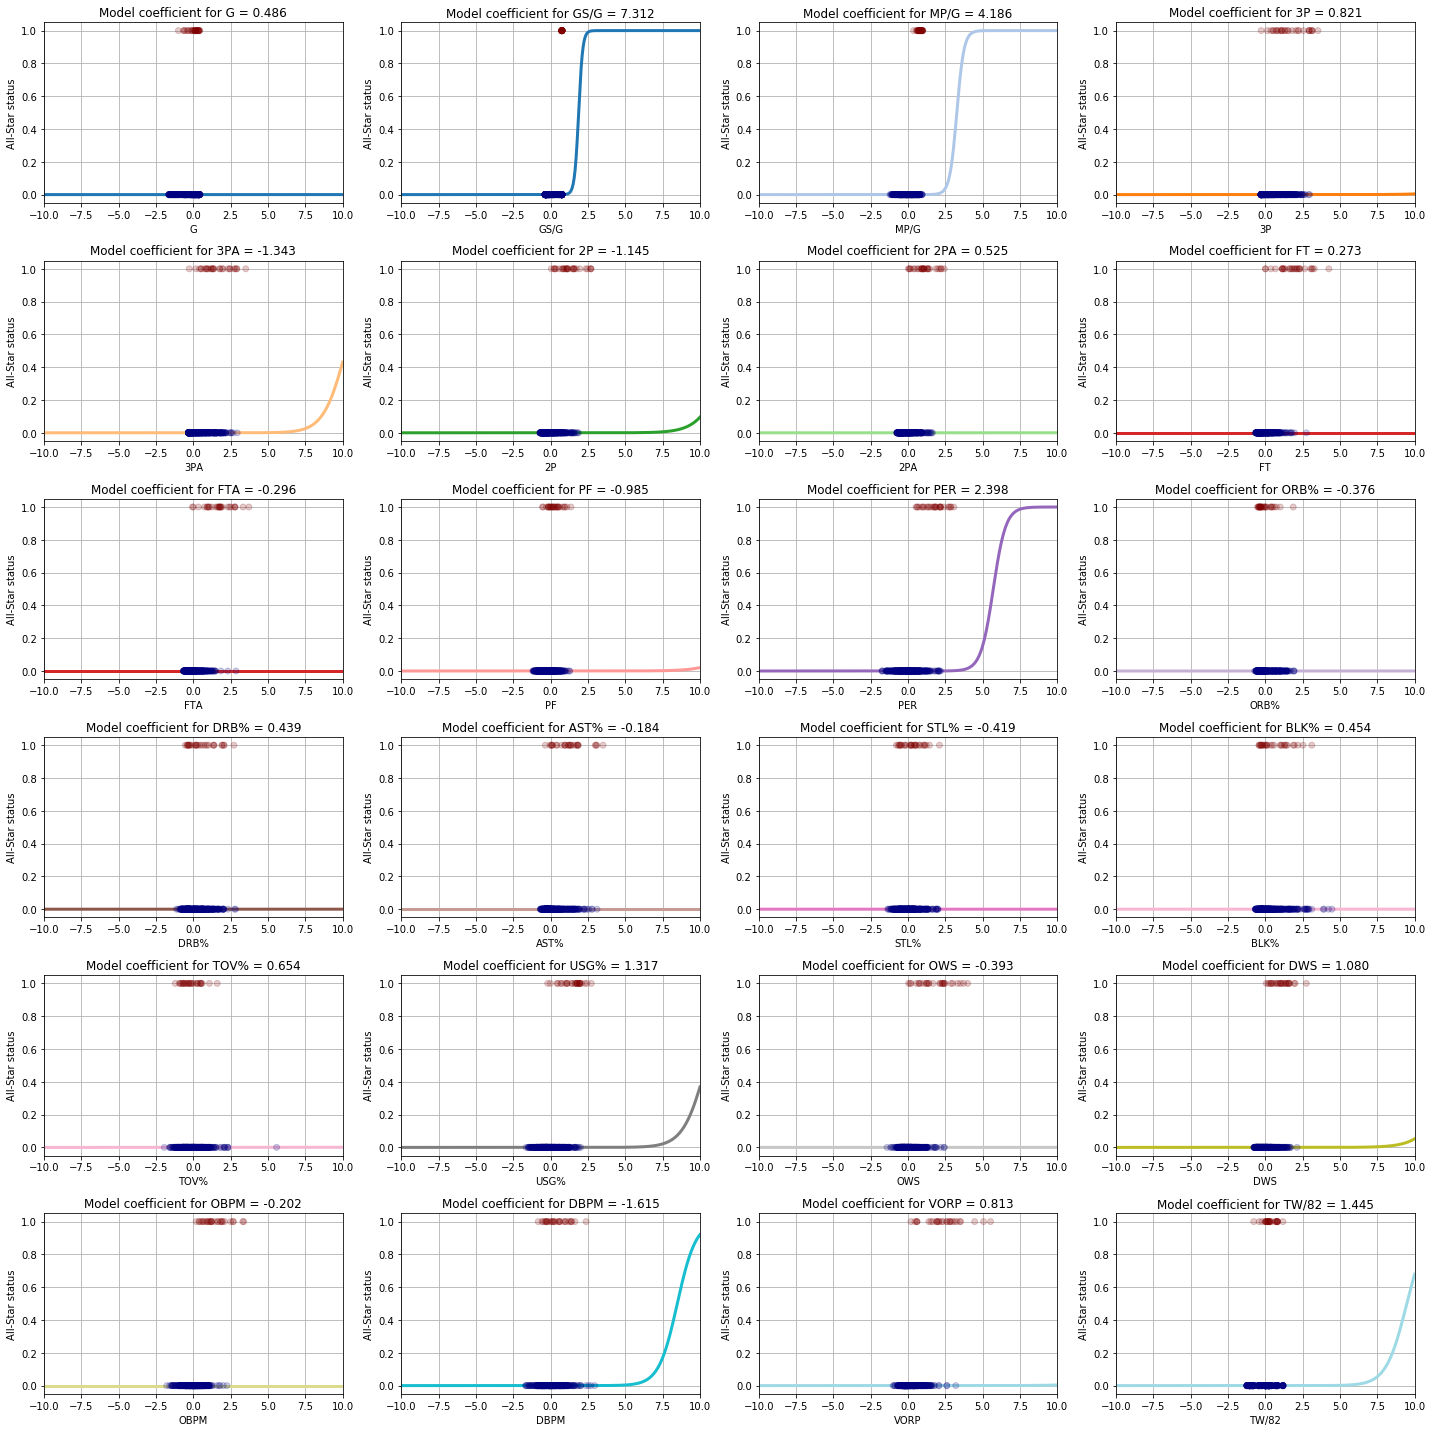

In [23]:
model = models[0].estimator # Logistic Regression Classifier

color=iter(plt.cm.tab20(np.linspace(0,1,24)))    

feature_linspace = np.linspace(-10, 10, 300)

plt.figure(figsize=(20,20))

for i, (feature_name, coefficient) in enumerate(zip(feature_names, model.coef_.ravel())):
    
    plt.subplot(6,4,i+1)

    feature_data  = X_test[:,i]
    ASstatus_data = y_test.ravel()
    
    plt.scatter(feature_data, ASstatus_data, c=ASstatus_data, cmap='jet', alpha=.2, zorder=20)
        
    logfunc = NBAanalysissetup.logistic_function(feature_linspace*abs(coefficient) + model.intercept_).ravel()

    plt.plot(feature_linspace, logfunc, color=next(color), linewidth=3, label=feature_name)

    plt.xlim([-10, 10])
    plt.ylim([-0.05, 1.05])
    plt.title("Model coefficient for {} = {:.3f}".format(feature_name, coefficient))
    plt.xlabel(feature_name)
    plt.ylabel('All-Star status')
    plt.grid(True)
    plt.tight_layout()

Check which players are All-Stars according to each fitted model:

In [24]:
for model in models:

    y_prediction = model.y_prediction
    y_truth      = model.y_truth
    
    print("==> Checking which players are All-Stars in {} according to {} ...".format(test_year, 
                                                                                      model.estimator_name))
    print("")

    TN_players = []
    FP_players = []
    FN_players = []
    TP_players = []
    
    for i in range(len(y_prediction)):
    
        player_name = df_test.iat[i,0] # 0-th column in df is player name
    
        if ((y_truth[i] == 0) and (y_prediction[i] == 0)):   # TN
            TN_players.append(player_name)
        elif ((y_truth[i] == 0) and (y_prediction[i] == 1)): # FP
            FP_players.append(player_name)
        elif ((y_truth[i] == 1) and (y_prediction[i] == 0)): # FN
            FN_players.append(player_name)
        else:                                                # TP
            TP_players.append(player_name)
        
    print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
    print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
    print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
    print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
    print("")
    print("--> Deserved true All-Stars:     ", TP_players)
    print("")
    print("--> Questionable true All-Stars: ", FN_players)
    print("")
    print("--> Snubbed non-All-Stars:       ", FP_players)
    print("")

==> Checking which players are All-Stars in 2018 according to Logistic Regression Classifier ...

--> # of     All-Stars predicted to be     All-Stars =  17 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  11 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   2 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 370 (TN)

--> Deserved true All-Stars:      ['LaMarcus Aldridge', 'Giannis Antetokounmpo', 'Jimmy Butler', 'DeMarcus Cousins', 'Stephen Curry', 'Anthony Davis', 'DeMar DeRozan', 'Andre Drummond', 'Kevin Durant', 'Joel Embiid', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Damian Lillard', 'Victor Oladipo', 'Karl-Anthony Towns', 'Russell Westbrook']

--> Questionable true All-Stars:  ['Bradley Beal', 'Goran Dragic', 'Paul George', 'Draymond Green', 'Al Horford', 'Kevin Love', 'Kyle Lowry', 'Kristaps Porzingis', 'Klay Thompson', 'Kemba Walker', 'John Wall']

--> Snubbed non-All-Stars:        ['Clint Capela', 'Chris Paul']

==> Checking which play

Calculate prediction scores for all models:

In [25]:
for model in models:

    classifier = model.estimator

    print("==> Model scores for top-50 players in {} according to {}:".format(test_year, model.estimator_name))
    print("")

    if hasattr(classifier, "predict_proba"):
        y_score = classifier.predict_proba(X_test)
    else:
        y_score = classifier.decision_function(X_test)
    
    player_score_dict = {}
    player_AS_dict    = {}

    if includeadvancedstats:
        AS_index = 51
    else:
        AS_index = 31
    
    for i in range(len(y_prediction)):
        
        player_name = df_test.iat[i,0]
        
        if hasattr(classifier, "predict_proba"):
            player_score_dict[player_name] = y_score[i].ravel()[1]
        else:
            player_score_dict[player_name] = y_score[i].ravel()[0]
    
        if df_test.iat[i,AS_index] > 0.5:
            status = 'All-Star'
        else:
            status = 'Non-All-Star'
        player_AS_dict[player_name] = status
        
    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    printed_line = False
    
    for i, (key, value) in enumerate(dict(sorted_player_score_dict[:50]).items(), 1):
        
        if hasattr(classifier, "predict_proba"):
            if (value < 0.5 and not printed_line):
                print("***********************************************************")
                printed_line = True
        else:
            if (value < 0 and not printed_line):
                print("***********************************************************")
                printed_line = True

        print("----> {:3}: {:24} = {:6.3f} ({})".format(i, key, value, player_AS_dict[key]))
        
    print("")

==> Model scores for top-50 players in 2018 according to Logistic Regression Classifier:

---->   1: James Harden             =  0.999 (All-Star)
---->   2: Kevin Durant             =  0.996 (All-Star)
---->   3: LeBron James             =  0.995 (All-Star)
---->   4: Anthony Davis            =  0.993 (All-Star)
---->   5: Stephen Curry            =  0.990 (All-Star)
---->   6: Damian Lillard           =  0.978 (All-Star)
---->   7: Giannis Antetokounmpo    =  0.974 (All-Star)
---->   8: Russell Westbrook        =  0.972 (All-Star)
---->   9: Kyrie Irving             =  0.952 (All-Star)
---->  10: DeMarcus Cousins         =  0.903 (All-Star)
---->  11: LaMarcus Aldridge        =  0.882 (All-Star)
---->  12: Joel Embiid              =  0.875 (All-Star)
---->  13: Karl-Anthony Towns       =  0.812 (All-Star)
---->  14: Victor Oladipo           =  0.783 (All-Star)
---->  15: Chris Paul               =  0.763 (Non-All-Star)
---->  16: Jimmy Butler             =  0.669 (All-Star)
---->  17:

---->   1: Giannis Antetokounmpo    =  0.990 (All-Star)
---->   2: LeBron James             =  0.970 (All-Star)
---->   3: Russell Westbrook        =  0.970 (All-Star)
---->   4: James Harden             =  0.950 (All-Star)
---->   5: Anthony Davis            =  0.930 (All-Star)
---->   6: Damian Lillard           =  0.820 (All-Star)
---->   7: LaMarcus Aldridge        =  0.790 (All-Star)
---->   8: Kevin Durant             =  0.790 (All-Star)
---->   9: DeMar DeRozan            =  0.730 (All-Star)
---->  10: Victor Oladipo           =  0.700 (All-Star)
---->  11: Joel Embiid              =  0.690 (All-Star)
---->  12: Kyrie Irving             =  0.670 (All-Star)
---->  13: Jimmy Butler             =  0.630 (All-Star)
---->  14: Kemba Walker             =  0.610 (All-Star)
---->  15: Karl-Anthony Towns       =  0.580 (All-Star)
***********************************************************
---->  16: Blake Griffin            =  0.470 (Non-All-Star)
---->  17: DeMarcus Cousins         =  0

Print test features of any particular player:

## Ensemble model

Create an ensemble model from ML classifier list using *VotingClassifier* class with majority voting:

In [26]:
classification_algs = []

for model in models:
    clf_tuple = (model.estimator_name, model.estimator)
    classification_algs.append(clf_tuple)
    
ensemble = VotingClassifier(estimators=classification_algs, voting='hard')

Cross-validate ensemble model:

In [27]:
note1 = " (Answers the question: How many predicted All-Stars are true All-Stars?)"
note2 = " (Answers the question: How many true All-Stars have been predicted?)"
note3 = " (i.e. the harmonic mean of Precision and Recall)"
note4 = " (Answers the question: How many AS and non-AS have been correctly predicted?)"

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

scoring_list = ['precision', 'recall', 'f1', 'accuracy']

rts = False

scores = cross_validate(ensemble, X_train, y_train, cv=cv_logo, scoring=scoring_list, return_train_score=rts) #, n_jobs=-1)

print("--> Total fit   time = {:5.1f} secs".format(scores['fit_time'  ].sum()))
print("--> Total score time = {:5.1f} secs".format(scores['score_time'].sum()))
print("")    
print("--> Cross-val years  :", ["{:6d}".format(yr) for yr in train_years])
print("")
print("--> Precision scores :", ["{:6.1%}".format(i) for i in scores['test_precision']])
print("--> Recall    scores :", ["{:6.1%}".format(i) for i in scores['test_recall'   ]])
print("--> F1        scores :", ["{:6.1%}".format(i) for i in scores['test_f1'       ]])
print("--> Accuracy  scores :", ["{:6.1%}".format(i) for i in scores['test_accuracy' ]])
print("")
print("--> Precision score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_precision']), 
                                                         np.std (scores['test_precision'])) + note1)
print("--> Recall    score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_recall'   ]), 
                                                         np.std (scores['test_recall'   ])) + note2)
print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_f1'       ]), 
                                                         np.std (scores['test_f1'       ])) + note3)
print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_accuracy' ]), 
                                                         np.std (scores['test_accuracy' ])) + note4)

--> Total fit   time = 161.2 secs
--> Total score time =  14.4 secs

--> Cross-val years  : ['  2000', '  2001', '  2002', '  2003', '  2004', '  2005', '  2006', '  2007', '  2008', '  2009', '  2010', '  2011', '  2012', '  2013', '  2014', '  2015', '  2016', '  2017']

--> Precision scores : ['100.0%', ' 73.1%', ' 89.5%', ' 89.5%', ' 95.0%', ' 90.5%', ' 82.6%', ' 78.6%', ' 81.0%', ' 93.8%', ' 88.9%', ' 81.8%', ' 92.9%', ' 75.0%', ' 75.0%', '100.0%', ' 90.5%', ' 76.0%']
--> Recall    scores : [' 62.5%', ' 73.1%', ' 65.4%', ' 68.0%', ' 79.2%', ' 79.2%', ' 76.0%', ' 75.9%', ' 65.4%', ' 57.7%', ' 57.1%', ' 75.0%', ' 52.0%', ' 48.0%', ' 62.5%', ' 64.3%', ' 73.1%', ' 76.0%']
--> F1        scores : [' 76.9%', ' 73.1%', ' 75.6%', ' 77.3%', ' 86.4%', ' 84.4%', ' 79.2%', ' 77.2%', ' 72.3%', ' 71.4%', ' 69.6%', ' 78.3%', ' 66.7%', ' 58.5%', ' 68.2%', ' 78.3%', ' 80.9%', ' 76.0%']
--> Accuracy  scores : [' 97.6%', ' 96.3%', ' 97.1%', ' 97.2%', ' 98.4%', ' 98.2%', ' 97.5%', ' 96.7%', ' 96.6%', 

Fit ensemble to training data and check which players are All-Stars according to the ensemble model:

In [28]:
ensemble.fit(X_train, y_train)          # Fit ensemble to training data

y_prediction = ensemble.predict(X_test) # Use fitted ensemble on prediction data

y_truth = y_test.tolist()

TN_players = []
FP_players = []
FN_players = []
TP_players = []
    
for i in range(len(y_prediction)):
    
    player_name = df_test.iat[i,0] # 0-th column in df is player name
    
    if ((y_truth[i] == 0) and (y_prediction[i] == 0)):   # TN
        TN_players.append(player_name)
    elif ((y_truth[i] == 0) and (y_prediction[i] == 1)): # FP
        FP_players.append(player_name)
    elif ((y_truth[i] == 1) and (y_prediction[i] == 0)): # FN
        FN_players.append(player_name)
    else:                                          # TP
        TP_players.append(player_name)
        
print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
print("")
print("--> Deserved true All-Stars:     ", TP_players)
print("")
print("--> Questionable true All-Stars: ", FN_players)
print("")
print("--> Snubbed non-All-Stars:       ", FP_players)

--> # of     All-Stars predicted to be     All-Stars =  16 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  12 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   1 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 371 (TN)

--> Deserved true All-Stars:      ['LaMarcus Aldridge', 'Giannis Antetokounmpo', 'Jimmy Butler', 'Stephen Curry', 'Anthony Davis', 'DeMar DeRozan', 'Andre Drummond', 'Kevin Durant', 'Joel Embiid', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Damian Lillard', 'Victor Oladipo', 'Karl-Anthony Towns', 'Russell Westbrook']

--> Questionable true All-Stars:  ['Bradley Beal', 'DeMarcus Cousins', 'Goran Dragic', 'Paul George', 'Draymond Green', 'Al Horford', 'Kevin Love', 'Kyle Lowry', 'Kristaps Porzingis', 'Klay Thompson', 'Kemba Walker', 'John Wall']

--> Snubbed non-All-Stars:        ['Chris Paul']


Check classification results per classifier in the ensemble model:

In [29]:
y_classification = ensemble.transform(X_test) # Class labels predicted per classifier in ensemble

player_scores_dict    = {}
player_sumscores_dict = {}
        
for i in range(len(X_test)):
    player_name         = df_test.iat[i,0]
    classification_list = y_classification[i]
    classification_sum  = np.sum(classification_list)
    player_scores_dict   [player_name] = classification_list
    player_sumscores_dict[player_name] = classification_sum

sorted_player_sumscores_dict = sorted(player_sumscores_dict.items(), key=operator.itemgetter(1), reverse=True)

print("--> Sum of ML classifiers for top-50 players in {}:".format(test_year))
print("")

printed_line = False
for i, (key, value) in enumerate(dict(sorted_player_sumscores_dict[:50]).items(), 1):
    if (value <= (len(models)/2) and not printed_line):
        print("*********************************************************************************")
        printed_line = True
    print("----> {:3}: {:24} = {:2d} {} ({})".format(i, key, value, player_scores_dict[key], player_AS_dict[key]))

--> Sum of ML classifiers for top-50 players in 2018:

---->   1: Giannis Antetokounmpo    = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->   2: Anthony Davis            = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->   3: DeMar DeRozan            = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->   4: Kevin Durant             = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->   5: Joel Embiid              = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->   6: James Harden             = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->   7: Kyrie Irving             = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->   8: LeBron James             = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->   9: Damian Lillard           = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->  10: Karl-Anthony Towns       = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->  11: Russell Westbrook        = 12 [1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->  12: LaMarcus Aldridge        = 11 [1 0 1 1 1 1 1 1 1 1 1 1] (All-Star)
---->  13

#### Supervised Learning Conclusion: 

The supervised algorithms tested in this analysis are able to predict the NBA All-Stars reasonably well in terms of precision, recall, etc..